# Hyper-Parameter Tuning using Optuna


To install Optuna library execute pip install optuna

In [ ]:
pip install optuna

### Required packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.svm import SVR
import optuna as op
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [ ]:
def evalmetric(y,ypred):
 import numpy as np
 e = y - ypred
 mse_f = np.mean(e**2)
 rmse_f = np.sqrt(mse_f)
 mae_f = np.mean(abs(e))
 mape_f = 100*np.mean(abs(e/y))
 r2_f = 1-(sum(e**2)/sum((y-np.mean(y))**2))
 print("MSE:", mse_f)
 print("RMSE:", rmse_f)
 print("MAE:",mae_f)
 print("MAPE:",mape_f)
 print("R-Squared:", r2_f)

### Fetching dataset


In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/ogut77/DataScience/main/data/CCPP.csv")

df.head()

AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90

Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE) of the plant.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


### Feature and Target Selection


In [ ]:
X=df.drop("PE",axis=1)
Y=df.PE

### Splitting Dataset


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

In [ ]:
print("train: ",X_train.shape)
print("test: ",X_test.shape)

train:  (7654, 4)
test:  (1914, 4)


### Baseline Model

First we will create a model without any parameter tuning to understand effect of parameter tuning at the later stage

In [ ]:
model=SVR()
model.fit(X_train,y_train)

SVR()

#### Model accuracy

In [ ]:
y_pred = model.predict(X_test)
evalmetric(y_test,y_pred)

MSE: 176.7662832841867
RMSE: 13.295348182134482
MAE: 11.103633135830277
MAPE: 2.422919335892963
R-Squared: 0.389227875807325


### Optuna Hyperparameter Tuning

In this section we will try to maximize our accuracy using different hyperparameter tunning available for SVM model.

Tuning parameters of SVM:

1. Kernel - Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’.
2. C - Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
3. degree - Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
4. gamma - Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.


In [ ]:
def objective(trial):
    kernel=trial.suggest_categorical('kernel',['rbf','poly','linear','sigmoid'])
    c=trial.suggest_float("C",0.1,3.0,log=True)
    gamma=trial.suggest_categorical('gamma',['auto','scale'])
    degree=trial.suggest_int("degree",1,3,log=True)
    model =SVR(kernel=kernel,degree=degree,gamma=gamma,C=c)
    model.fit(X_train,y_train)
    accuracy = model.score(X_test,y_test)
    return accuracy

In [ ]:
#optuna study record
study = op.create_study(direction="maximize")
study.optimize(objective, n_trials=20,n_jobs=-1)

[I 2022-04-01 04:59:26,470] A new study created in memory with name: no-name-0f8953a2-09e5-495a-addd-3457634fb07e
[I 2022-04-01 04:59:28,876] Trial 1 finished with value: -0.033889012046907974 and parameters: {'kernel': 'sigmoid', 'C': 0.9323530683705877, 'gamma': 'auto', 'degree': 1}. Best is trial 1 with value: -0.033889012046907974.
[I 2022-04-01 04:59:37,225] Trial 2 finished with value: 0.92986037518757 and parameters: {'kernel': 'linear', 'C': 0.39578756023480366, 'gamma': 'scale', 'degree': 2}. Best is trial 2 with value: 0.92986037518757.
[I 2022-04-01 04:59:39,656] Trial 3 finished with value: -0.033889012046907974 and parameters: {'kernel': 'sigmoid', 'C': 0.8885150104183361, 'gamma': 'auto', 'degree': 1}. Best is trial 2 with value: 0.92986037518757.
[I 2022-04-01 04:59:43,541] Trial 4 finished with value: 0.9298981757594549 and parameters: {'kernel': 'poly', 'C': 0.2495024523902746, 'gamma': 'auto', 'degree': 1}. Best is trial 4 with value: 0.9298981757594549.
[I 2022-04-01

### Best result



In [ ]:
trial=study.best_trial
print("Best Tuning Parameters : {} \n with accuracy of : {:.2f} %".format(trial.params,trial.value))

Best Tuning Parameters : {'kernel': 'linear', 'C': 0.10540821019812002, 'gamma': 'auto', 'degree': 1} 
 with accuracy of : 0.92 %


### tuning Model

now we will use the obtained best parameter from the Optuna operation for fitting the model.

In [ ]:
#model with the return parameters
model_tunned=SVR(kernel='linear',
                C= 0.10540821019812002,
                gamma='auto',
                degree=1)
model_tunned.fit(X_train,y_train)

SVR(C=0.10540821019812002, degree=1, gamma='auto', kernel='linear')

### Accuracy


In [ ]:
y_predT = model_tunned.predict(X_test)
evalmetric(y_test,y_predT)

MSE: 22.45955991882792
RMSE: 4.73915181428364
MAE: 3.7479224924001753
MAPE: 0.828902665050708
R-Squared: 0.9223965517337867


### Study Plot of Optuna

The visualization module of optuna provides utility for plotting the optimization process using plotly and matplotlib. Plotting functions generally take a Study object and optional parameters are passed as a list to the params argument.

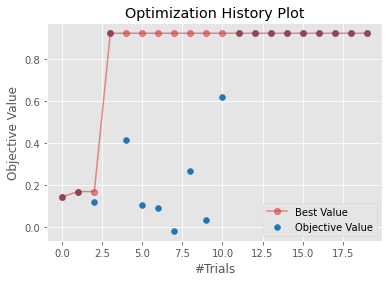

In [ ]:
op.visualization.matplotlib.plot_optimization_history(study)

Plot optimization history of all trials in a study.

The line plot indicates the best accuracy in complete trial run amongst all and  blue indicates individual trial accuracy.

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# instantiate the model (using the default parameters)
LR = LinearRegression()

# fit the model with data
LR.fit(X_train,y_train)

#
y_predLR=LR.predict(X_test)
evalmetric(y_test,y_predLR)

MSE: 22.127759402996112
RMSE: 4.704015242640708
MAE: 3.743797176753162
MAPE: 0.8275276750396894
R-Squared: 0.9235430062617523


In [ ]:
#To get the coeffient
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
LRM=sm.OLS(y_train,X2)
result=LRM.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 2.539e+04
Date:                Sat, 02 Apr 2022   Prob (F-statistic):               0.00
Time:                        08:27:03   Log-Likelihood:                -22407.
No. Observations:                7654   AIC:                         4.482e+04
Df Residuals:                    7649   BIC:                         4.486e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        458.1192     10.737     42.668      0.0

A) Which variables are significantly diffrent than 0 at 5% significant level?

B)Among signicant variables, which one increases dependent variable (Y)?

C)How can we interpret coefficent?

In [ ]:
corr = X_train.corr()

corr

AT         V        AP        RH
AT  1.000000  0.845196 -0.503637 -0.540861
V   0.845196  1.000000 -0.413232 -0.308697
AP -0.503637 -0.413232  1.000000  0.099628
RH -0.540861 -0.308697  0.099628  1.000000

## K-Nearest Neighbour- kNN with Parameter Optimization

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
from sklearn.model_selection import GridSearchCV, cross_val_score

knn_params = {"n_neighbors": range(2,50)}

knn_grid = GridSearchCV(knn, knn_params, cv=5)

knn_grid.fit(X_train, y_train)
print(knn_grid.best_params_)
knncv = KNeighborsRegressor(**knn_grid.best_params_)
# fit the model with data
knncv.fit(X_train,y_train)
#
y_predknncv=knncv.predict(X_test)
evalmetric(y_test,y_predknncv)

{'n_neighbors': 5}
MSE: 16.159022085684406
RMSE: 4.019828613969059
MAE: 2.8937053291536063
MAPE: 0.6381858905511282
R-Squared: 0.9441665001900692


## Boosting

In [ ]:
import optuna

import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm


# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    x, y = X_train,y_train

    regressor_name = trial.suggest_categorical("regressor", ["GradientBoosting", "XGBoost","LightGBM","RandomForest"])
    if regressor_name == "GradientBoosting":
         max_depth = trial.suggest_int("max_depth", 2,16)
         max_features = trial.suggest_int("max_features", 2,X_train.shape[1])
         regressor_obj = sklearn.ensemble.GradientBoostingRegressor(random_state=17,  max_depth=max_depth, max_features=max_features )

    elif regressor_name == "XGBoost":
         from xgboost import XGBRegressor
         max_depth = trial.suggest_int("max_depth", 2,X_train.shape[1])
         max_features = trial.suggest_int("max_features", 2,X_train.shape[1])
         regressor_obj = XGBRegressor(random_state=17,  max_depth=max_depth, max_features=max_features )



    elif regressor_name == "LightGBM":
         import lightgbm as lgb
         max_depth = trial.suggest_int("max_depth", 2,X_train.shape[1])
         max_features = trial.suggest_int("max_features", 2,X_train.shape[1])
         regressor_obj = lgb.LGBMRegressor(random_state=17,  max_depth=max_depth, max_features=max_features )



    else:
         max_depth = trial.suggest_int("max_depth", 2,16)
         max_features = trial.suggest_int("max_features", 2,X_train.shape[1])
         regressor_obj = sklearn.ensemble.RandomForestRegressor(random_state=17,  max_depth=max_depth, max_features=max_features )



    r2=sklearn.model_selection.cross_val_score(regressor_obj, x, y, n_jobs=-1, cv=3).mean()

    return r2


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)
    print(study.best_trial)
    print(study.best_params)

[I 2022-04-02 08:38:00,869] A new study created in memory with name: no-name-c24883eb-a9f1-4386-ae71-24a7ee82bb7a
[I 2022-04-02 08:38:03,717] Trial 0 finished with value: 0.9620680251257813 and parameters: {'regressor': 'GradientBoosting', 'max_depth': 9, 'max_features': 3}. Best is trial 0 with value: 0.9620680251257813.
[I 2022-04-02 08:38:03,819] Trial 1 finished with value: 0.9432868995923753 and parameters: {'regressor': 'LightGBM', 'max_depth': 2, 'max_features': 3}. Best is trial 0 with value: 0.9620680251257813.
[I 2022-04-02 08:38:06,807] Trial 2 finished with value: 0.9592205222985974 and parameters: {'regressor': 'GradientBoosting', 'max_depth': 15, 'max_features': 2}. Best is trial 0 with value: 0.9620680251257813.
[I 2022-04-02 08:38:07,416] Trial 3 finished with value: 0.950806764028192 and parameters: {'regressor': 'XGBoost', 'max_depth': 4, 'max_features': 2}. Best is trial 0 with value: 0.9620680251257813.
[I 2022-04-02 08:38:09,825] Trial 4 finished with value: 0.9521

FrozenTrial(number=7, values=[0.9621214909999214], datetime_start=datetime.datetime(2022, 4, 2, 8, 38, 12, 358697), datetime_complete=datetime.datetime(2022, 4, 2, 8, 38, 14, 556003), params={'regressor': 'GradientBoosting', 'max_depth': 10, 'max_features': 2}, distributions={'regressor': CategoricalDistribution(choices=('GradientBoosting', 'XGBoost', 'LightGBM', 'RandomForest')), 'max_depth': IntUniformDistribution(high=16, low=2, step=1), 'max_features': IntUniformDistribution(high=4, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=7, state=TrialState.COMPLETE, value=None)
{'regressor': 'GradientBoosting', 'max_depth': 10, 'max_features': 2}


In [ ]:
params={ 'max_depth': 10, 'max_features': 2}
from sklearn.ensemble import GradientBoostingRegressor
from time import time

gbr = GradientBoostingRegressor(random_state=17,**params)
gbr.fit(X_train, y_train)
print('Train Data')
y_pred = gbr.predict(X_train)
evalmetric(y_train,y_pred)
print('Test Data')
y_pred2 = gbr.predict(X_test)
evalmetric(y_test,y_pred2)

Train Data
MSE: 0.648136154792214
RMSE: 0.8050690372832717
MAE: 0.6185153466824876
MAPE: 0.13687130199958483
R-Squared: 0.9977779278030013
Test Data
MSE: 9.953909964160772
RMSE: 3.154981769227957
MAE: 2.177816344829164
MAPE: 0.4815497669837414
R-Squared: 0.9656067287274519


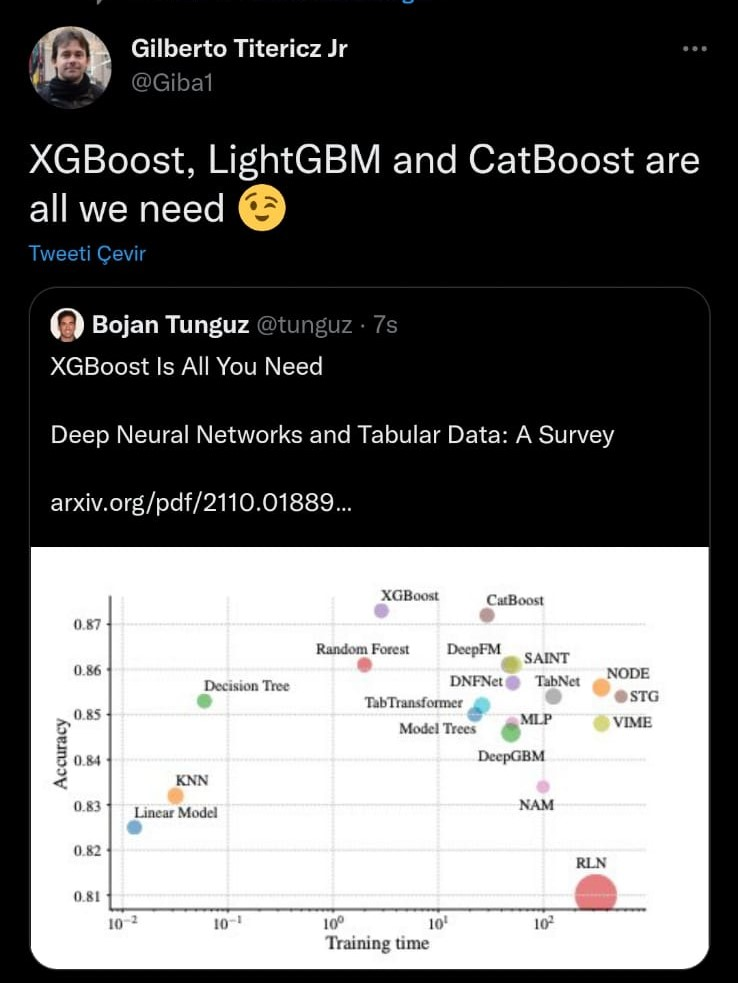

## Automatic Machine Learning (Auto ML)

In [ ]:
!pip install pycaret

In [3]:
#reload data and eval function
import pandas as pd
from sklearn.model_selection import train_test_split
df=pd.read_csv("https://raw.githubusercontent.com/ogut77/DataScience/main/data/CCPP.csv")
X=df.drop("PE",axis=1)
Y=df.PE
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=123)
def evalmetric(y,ypred):
 import numpy as np
 e = y - ypred
 mse_f = np.mean(e**2)
 rmse_f = np.sqrt(mse_f)
 mae_f = np.mean(abs(e))
 mape_f = 100*np.mean(abs(e/y))
 r2_f = 1-(sum(e**2)/sum((y-np.mean(y))**2))
 print("MSE:", mse_f)
 print("RMSE:", rmse_f)
 print("MAE:",mae_f)
 print("MAPE:",mape_f)
 print("R-Squared:", r2_f)

In [4]:
result = pd.concat([X_train, y_train], axis=1)
result

AT      V       AP     RH      PE
2678  18.95  42.23  1013.01  79.40  462.73
370   23.19  48.60  1002.38  61.19  445.52
6951  21.97  58.79  1010.93  86.70  448.80
1562  26.93  72.99  1007.33  78.85  433.18
6993  27.14  64.27  1012.71  54.40  441.68
...     ...    ...      ...    ...     ...
7382  13.67  38.53  1009.30  81.85  470.39
7763  15.12  41.04  1025.95  69.67  460.58
5218   7.91  38.56  1016.48  68.94  485.95
1346  19.09  56.51  1015.58  92.56  449.24
3582  25.95  59.27  1010.90  70.42  444.19

[7654 rows x 5 columns]

In [5]:
#!pip install --upgrade numpy
from pycaret.regression import *
s = setup(data = result, target = 'PE', session_id=123)

In [7]:
best_model = compare_models()

Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [9]:
tuned2 = tune_model(best_model)
tuned_predictions = predict_model(tuned2, data=X_test)
tuned_predictions.head()


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


AT          V           AP         RH  prediction_label
6503  23.91  50.230000  1017.250000  68.570000        453.348724
1586  28.40  59.270000  1012.030029  59.750000        439.176361
7033  13.86  35.709999  1015.210022  63.160000        468.451447
1484   8.83  36.299999  1027.079956  72.690002        480.320312
6938  25.77  58.590000  1012.510010  55.840000        447.820190

In [10]:
evalmetric(y_test,tuned_predictions['prediction_label'])

MSE: 12.006757004130034
RMSE: 3.465076767422337
MAE: 2.409436308762123
MAPE: 0.5318081094263715
R-Squared: 0.9585136240699935
